<hr>
<center><b>Machine learning sur les données tabmo</center> <br>
<center><b>Over sampling </center> <br>
<hr>

# Objectif 

# Import

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from jupyterthemes import jtplot
from sklearn import preprocessing
from sklearn.preprocessing import scale, normalize
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report
from sklearn import metrics
from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC, LinearSVC
sns.set(style="whitegrid")

# Data import & exploration

In [5]:
df = pd.read_csv("data_one_month_cleaned.csv", low_memory=False)
print("Taille :",df.shape,
     "\nVariables :",df.columns) 

Taille : (92056, 78) 
Variables : Index(['auction_id', 'click', 'exchange', 'app_or_site', 'has_gps',
       'device_type', 'connection_type', 'creative_size', 'has_ifa',
       'win_price', 'win_price_loc', 'bidder_name', 'Device_language',
       'Country_language', 'Device_lg_Equals_country_lg', 'Continent',
       'Country_name', 'City', 'Timestamp', 'IAB1', 'IAB1%', 'IAB10', 'IAB11',
       'IAB12', 'IAB13', 'IAB14', 'IAB15', 'IAB16', 'IAB17', 'IAB18', 'IAB19',
       'IAB2', 'IAB20', 'IAB21', 'IAB22', 'IAB23', 'IAB24', 'IAB26', 'IAB3',
       'IAB3%', 'IAB4', 'IAB5', 'IAB6', 'IAB7', 'IAB8', 'IAB9', 'IAB9%',
       'books', 'busin', 'educa', 'enter', 'finan', 'games', 'healt', 'lifes',
       'medic', 'music', 'navig', 'news', 'photo', 'produ', 'refer', 'socia',
       'sport', 'trave', 'unkno', 'utili', 'weath', 'fullOsInfo',
       'Timestamp_second', 'Timestamp_minute', 'Timestamp_hour',
       'Timestamp_DayOfWeek', 'Timestamp_DayOfMonth', 'Timestamp_Month',
       'Days_Since

# Data cleaning

In [6]:
df.drop(['auction_id', 'win_price_loc', 'Campaign_Duration',
         'Timestamp','Timestamp_Month'],axis = 1, inplace = True)
creative_size = df['creative_size'].str.split('x',expand=True)
df['creative_size1'] = creative_size[0]
df['creative_size2'] = creative_size[1]
df['win_price'] = pd.qcut(df["win_price"],10)
df['Timestamp_hour'] = pd.cut(df.Timestamp_hour, 4, labels=['nuit','Matin','Aprem','Soir'])
df['Timestamp_minute'] = pd.cut(df.Timestamp_minute,4)
df.drop("creative_size", axis=1, inplace=True)
y_0_X = df[df['click'] == 0]
y_0_X_reduced = y_0_X.sample(frac=0.50)
df = pd.concat([y_0_X_reduced,df[df['click'] == 1]])

## Get Labels values

In [7]:
le = preprocessing.LabelEncoder()
for i in range(len(df.columns)):
    le.fit(list(df[df.columns[i]].value_counts().index))
    df[df.columns[i]]=le.transform(df[df.columns[i]]) 
y = df['click']
X = df.drop(['click'],axis =1)

## SVD for dimensionnal reduction

In [8]:
svd = TruncatedSVD(n_components=10, n_iter=7, random_state=42)
X_normalized = normalize(X) # Normalize before svd
X_transformed = svd.fit_transform(X_normalized)
print("Pourcentage d'inertie : ", svd.explained_variance_ratio_.sum())

Pourcentage d'inertie :  0.9869179266410516


In [9]:
## Concatenate dataframe for modelization
X = pd.DataFrame(X_transformed)
print("Shape before SVD : ",X.shape,"\nShape after SVD : ", X.shape,)

Shape before SVD :  (49403, 10) 
Shape after SVD :  (49403, 10)


In [10]:
X.head()

,0,1,2,3,4,5,6,7,8,9
0,0.899785,-0.070116,0.285947,-0.157796,0.042590,-0.234501,-0.113636,-0.049739,-0.022232,0.060873
1,0.930597,-0.096547,0.311966,-0.080453,0.027123,-0.017902,-0.025079,-0.104831,-0.017254,0.065140
2,0.767689,0.450106,-0.115546,0.290493,-0.267433,0.012437,-0.009008,-0.042623,-0.021745,-0.014857
3,0.902979,-0.357777,0.113404,0.053722,-0.110344,-0.120856,-0.094509,-0.040544,-0.050281,-0.011715
4,0.965086,-0.014702,-0.182578,0.022528,-0.120715,-0.076009,-0.061202,-0.072711,-0.006887,-0.025054


## Train & test sample split

In [11]:
X_train, X_test, y_train, y_test = train_test_split(
     X, y, test_size = 0.30, random_state = 42)

# Labels repartition

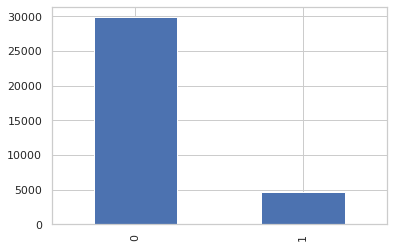

In [12]:
y_train.value_counts().plot(kind = 'bar')

# Oversampling

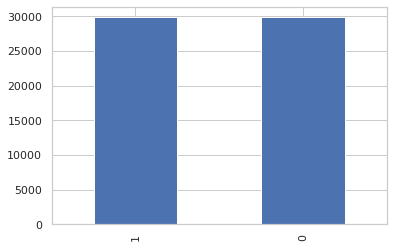

In [13]:
smt = SMOTE()
X_train, y_train = smt.fit_sample(X_train, y_train)
y_train.value_counts().plot(kind = 'bar')

# Les  modèles testés

## Support Vector Machine

     - Les SVM pour Support Vector Machines
     - Méthode de Boosting, AdaBoost et GradientBoosting

In [14]:
def svc_param_selection(X, y):
    Cs = [0.001, 0.01, 0.1, 1, 10, 25, 50, 75, 100]
    gammas = np.arange(0,1,0.1)
    param_grid = {'C': Cs, 'gamma' : gammas, 'kernel':('linear', 'rbf')}
    grid_search = GridSearchCV(SVC(kernel='rbf'), param_grid, cv=5)
    grid_search.fit(X, y)
    grid_search.best_params_
    return grid_search.best_params_

In [ ]:
clf_svm = svc_param_selection(X_train, y_train)